In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from markovBike.manager.manager import Manager
from markovBike.data_source.source import database_queries, get_stations_data, get_trips_data
from markovBike.data_source.preprocess import preprocess_stations_data, preprocess_trips_data

import pandas as pd

In [3]:
verbose = True

n_stations = 2_000

n_trips = 5_000

In [4]:
stations_raw = get_stations_data(database_queries(n_stations)['stations'], verbose=verbose)

stations_raw.head(3)

Bike station table with shape (1845, 18). Columns are: 

station_id                                object
name                                      object
short_name                                object
latitude                                 float64
longitude                                float64
region_id                                  Int64
rental_methods                            object
capacity                                   Int64
eightd_has_key_dispenser                 boolean
num_bikes_available                        Int64
num_bikes_disabled                         Int64
num_docks_available                        Int64
num_docks_disabled                         Int64
is_installed                             boolean
is_renting                               boolean
is_returning                             boolean
eightd_has_available_keys                boolean
last_reported                datetime64[ns, UTC]
dtype: object



,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


In [5]:
stations_raw = stations_raw[stations_raw['latitude'] != 0.0]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical_features = stations_raw.select_dtypes(include=numerics).columns.drop(
    ['region_id'])

categorical_features = stations_raw.select_dtypes(
    include='object').columns.drop(['station_id', 'name', 'short_name'
                                    ]).append(pd.Index(['region_id']))

boolean_features = stations_raw.select_dtypes(
    include='bool').columns

In [6]:
stations_preproc = preprocess_stations_data(
    stations_raw,
    index='station_id',
    drops=['name', 'short_name'],
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    boolean_features=boolean_features,
    verbose=verbose)

stations_dataframe = pd.DataFrame(stations_preproc[0]).dropna()# ,columns=stations_preproc[1])

stations_dataframe.head(3)


 📶 Columns['latitude', 'longitude', 'region_id', 'rental_methods', 'capacity', 'eightd_has_key_dispenser', 'num_bikes_available', 'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled', 'is_installed', 'is_renting', 'is_returning', 'eightd_has_available_keys', 'last_reported']

 📶 Numericals['latitude', 'longitude', 'capacity', 'num_bikes_available', 'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled']

 📶 Categoricals['rental_methods', 'region_id']

 📶 Booleans['eightd_has_key_dispenser', 'is_installed', 'is_renting', 'is_returning', 'eightd_has_available_keys']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.260316,-0.941186,-1.86506,-0.769971,-0.716346,-1.160722,-0.071971,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.639588,-0.540010,-1.86506,-0.769971,-0.716346,-1.160722,-0.071971,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.293977,0.752523,-1.86506,-0.769971,-0.716346,-1.160722,-0.071971,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


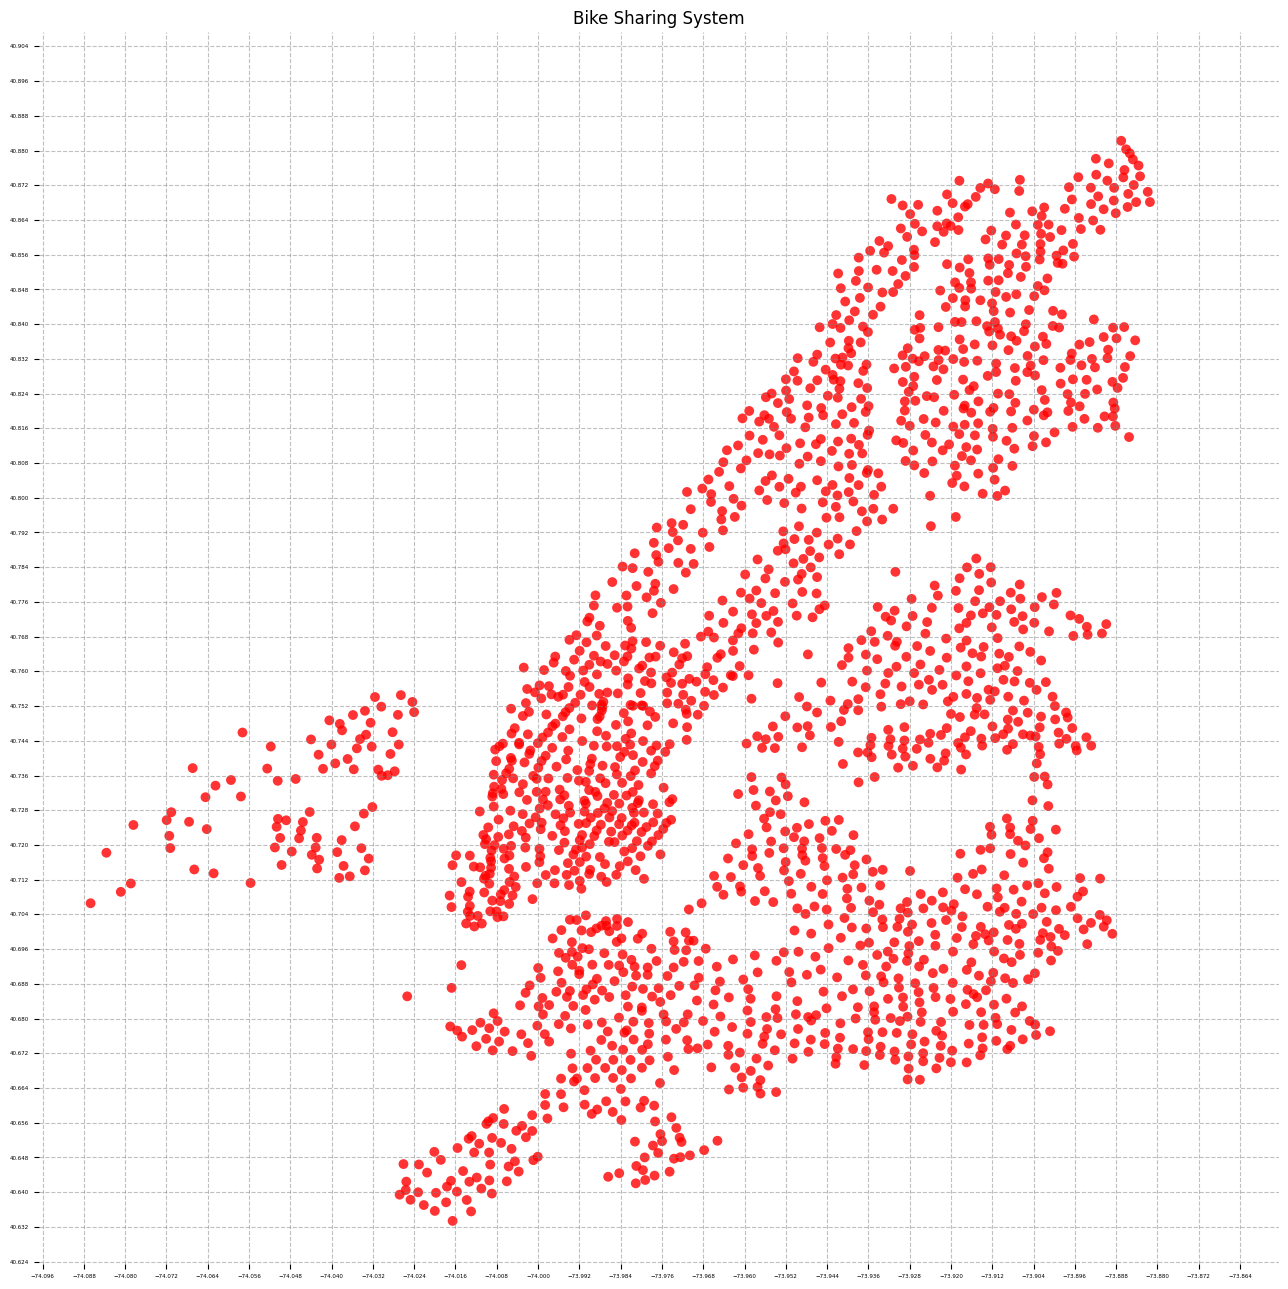

In [7]:
# Define the longitude and latitude of nodes

latitudes = list(stations_raw['latitude'])

longitudes = list(stations_raw['longitude'])

Manager.plot_nodes(latitudes, longitudes)


In [8]:
trips_raw = get_stations_data(database_queries(n_trips)['trips'], verbose=True)

Bike station table with shape (5000, 15). Columns are: 

tripduration                             Int64
starttime                  datetime64[ns, UTC]
stoptime                   datetime64[ns, UTC]
start_station_id                         Int64
start_station_name                      object
start_station_latitude                 float64
start_station_longitude                float64
end_station_id                           Int64
end_station_name                        object
end_station_latitude                   float64
end_station_longitude                  float64
bikeid                                   Int64
usertype                                object
birth_year                               Int64
gender                                  object
dtype: object



In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical_features = trips_raw.select_dtypes(include=numerics).columns.drop(
    ['start_station_id', 'end_station_id', 'bikeid'])

categorical_features = trips_raw.select_dtypes(include='object').columns.drop(
    ['start_station_name', 'end_station_name']).append(pd.Index(['start_station_id', 'end_station_id', 'bikeid'])).drop(['bikeid'])

boolean_features = trips_raw.select_dtypes(include='bool').columns


In [10]:
trips_preproc = preprocess_trips_data(
    trips_raw,
    drops=['start_station_name', 'end_station_name'],
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    boolean_features=boolean_features,
    verbose=True)

trips_dataframe = pd.DataFrame(trips_preproc[0],columns=trips_preproc[1]).dropna()

trips_dataframe.head(3)


 📶 Columns['tripduration', 'starttime', 'stoptime', 'start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype', 'birth_year', 'gender']

 📶 Numericals['tripduration', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year']

 📶 Categoricals['usertype', 'gender', 'start_station_id', 'end_station_id']

 📶 Booleans[]

 📶 Array shaped (5000, 556)

 📶 Columns names are 556: ['tripduration', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'usertype_Subscriber', 'gender_female', 'gender_male', 'gender_unknown', 'start_station_id_233.0', 'start_station_id_263.0', 'start_station_id_282.0', 'start_station_id_329.0', 'start_station_id_3016.0', 'start_station_id_3089.0', 'start_station_id_3100.0', 'start_station_id_3122.0', 'start_station_id_3131.0', 'start_station_id_315

/Users/juan-garassino/.pyenv/versions/3.10.6/envs/markovBike/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,birth_year,usertype_Subscriber,gender_female,gender_male,gender_unknown,...,end_station_id_3417.0,end_station_id_3418.0,end_station_id_3419.0,end_station_id_3422.0,end_station_id_3423.0,end_station_id_3424.0,end_station_id_3425.0,end_station_id_3427.0,end_station_id_3428.0,end_station_id_3431.0
0,0.123236,0.002197,1.572131,-0.736252,1.787758,0.548236,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.379084,0.002197,1.572131,0.816736,0.868778,1.235646,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.017163,0.002197,1.572131,-1.297174,0.804857,-0.568805,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Group the data by pairs of start and end stations, and count the number of trips between them
station_pairs = trips_raw.groupby(['start_station_id', 'end_station_id'
                                   ]).size().reset_index(name='trip_count')

# Group by start and end station id and count the trips
trip_counts = trips_raw.groupby(['start_station_id', 'end_station_id'
                                 ]).size().reset_index(name='trip_count')

# Merge the trip count DataFrame with the original bike trips DataFrame
trips_raw = trips_raw.merge(trip_counts,
                            on=['start_station_id', 'end_station_id'])

# Print the first few rows of the merged DataFrame
trips_raw.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trip_count
0,1257,2015-11-08 12:47:18+00:00,2015-11-08 13:08:16+00:00,3122,40.744363,-73.955873,3102,40.721791,-73.950415,14622,Subscriber,1983,male,1
1,1819,2016-03-12 15:07:43+00:00,2016-03-12 15:38:03+00:00,3122,40.744363,-73.955873,305,40.760958,-73.967245,20955,Subscriber,1991,male,1
2,1024,2016-05-16 07:22:51+00:00,2016-05-16 07:39:55+00:00,3122,40.744363,-73.955873,282,40.707645,-73.968415,22800,Subscriber,1970,male,1
3,2352,2016-06-06 17:58:29+00:00,2016-06-06 18:37:41+00:00,3122,40.744363,-73.955873,79,40.719116,-74.006667,25198,Subscriber,1964,male,1
4,1576,2015-10-18 16:12:03+00:00,2015-10-18 16:38:19+00:00,3122,40.744363,-73.955873,539,40.715348,-73.960241,15006,Subscriber,1984,female,1


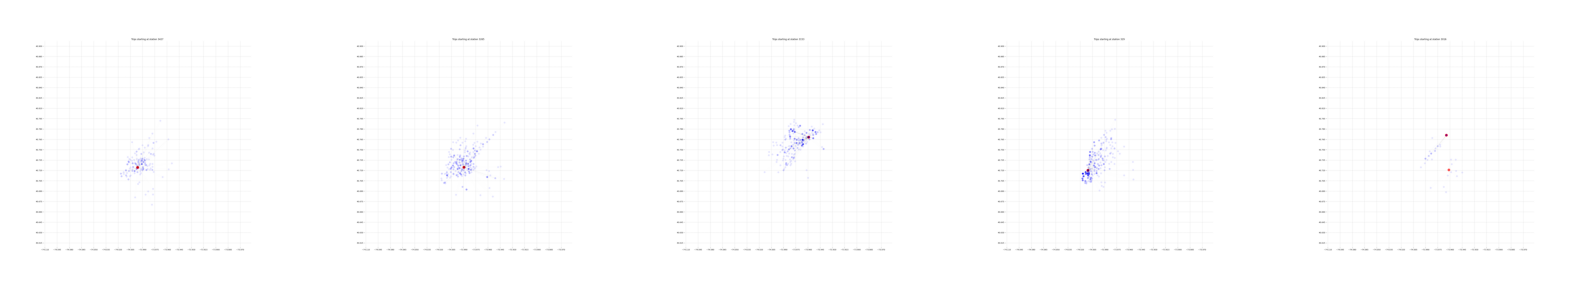

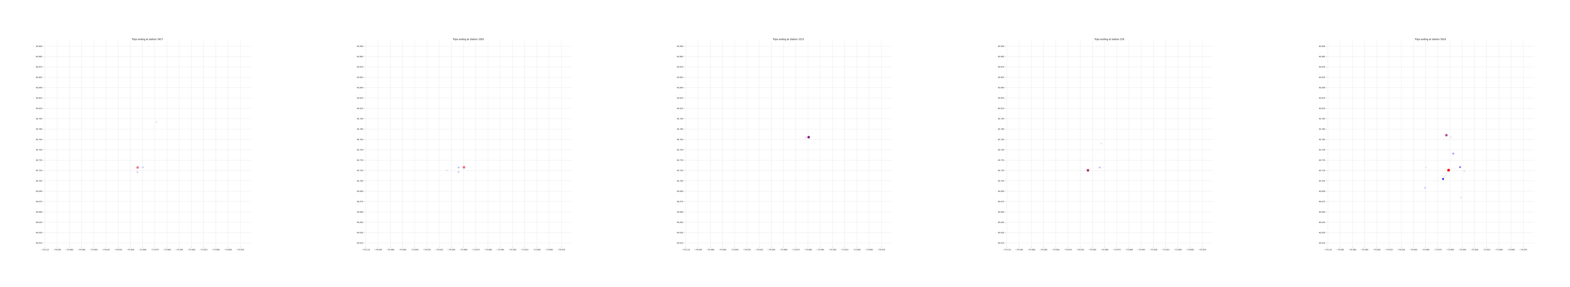

In [12]:
start_stations = list(trips_raw['start_station_id'].unique())

Manager.plot_subgraphs(trips_raw, start_stations, 5)
